In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import os
import matplotlib.colors as clrs
from IPython.core.display import display, HTML
import anndata
from sklearn.metrics import silhouette_score
from joblib import parallel_backend
import math
import pickle
import re

/tmp/ipykernel_2179587/1015272670.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
#from scipy.sparse import csr_matrix
#from scipy.io import mmwrite

In [75]:
sc.settings.verbosity=0
sc.settings.set_figure_params(dpi=100)
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                 10.4.0
asttokens           NA
bottleneck          1.3.7
cffi                1.15.1
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.0
executing           0.8.3
h5py                3.12.1
igraph              0.11.6
ipykernel           6.28.0
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.7
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
lxml                5.3.0
matplotlib          3.9.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.8.7
numpy               1.26.3
openpyxl            3.1.5
packaging           23.0
pandas              2.2.2
parso               0.8.3
patsy               0.5.6
pkg_resources       NA
platformdirs        3.10.0
plotly      

In [76]:
colors = [(0, ("#E0E0E0")), (0.25, ("#F1F1F1")), (1,("#FD0D0D"))]
n_bins = 250 # discretizes the interpolation into bins
cmap_name = "new_list"
cm_2 = clrs.LinearSegmentedColormap.from_list(cmap_name, colors , N = n_bins)

In [77]:
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [ ]:
#file_path = "/group/iorio/Raffaele/Project_ADD3/review/sc_CCLs_Broad/SCP542/other/matrix.txt"
#mat = np.loadtxt(file_path)
#sparse_mat = csr_matrix(mat)
#mtx_file = "/group/iorio/Raffaele/Project_ADD3/review/sc_CCLs_Broad/SCP542/other/matrix.mtx" 
#mmwrite(mtx_file, sparse_mat)

In [78]:
os.getcwd()

'/home/raffaele.iannuzzi/notebooks/scdresp_analysis'

In [79]:
#gdscat2=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSCatSquare-009_matrix_results.csv")
gdsc=pd.read_excel("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSC2_fitted_dose_response.xlsx")
gdsc.rename(columns={"SANGER_MODEL_ID":"SangerModelID"},inplace=True)
#gex=pd.read_csv("/group/iorio/Raffaele/Project_ADD3/review/depmap/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv",index_col=0)
#genes = [re.sub(r"\s*\(.*?\)", "", gene) for gene in gex.columns]
#gex.columns = genes
#gex=gex.reset_index().rename(columns={"index":"ModelID"})

In [80]:
metadata = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/Model.csv")

In [81]:
adata = sc.read_10x_mtx("/group/iorio/Raffaele/SCDRESP_data/data/raw_feature_bc_matrix/", var_names="gene_symbols",cache=True)

In [82]:
cl_type = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/cline.tsv", header=None)

In [83]:
cl_type.set_index(adata.obs_names, inplace=True)

In [84]:
adata.obs["cell_line"] = cl_type

In [85]:
sc_barcodes = adata.obs.index

In [86]:
adata.obs = pd.merge(adata.obs, metadata, how="left", left_on="cell_line", right_on="CCLEName")

In [87]:
# basic pre-processing
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)
print(adata.shape)

(56982, 30314)


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(56982, 24452)


In [88]:
len(adata.obs["ModelID"].unique())

203

In [ ]:
#nmads=3.5
#adata.obs["outlier"] = (
#    mad_filter(adata, "log1p_total_counts", nmads) | 
#    mad_filter(adata, "log1p_n_genes_by_counts", nmads)
#)
#adata.obs["mt_outlier"] = (
#    mad_filter(adata, "pct_counts_mt", nmads) | 
#    (adata.obs["pct_counts_mt"] > 8)
#)
#print(f"Total number of cells: {adata.n_obs}")
#adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
#print(f"Number of cells after filtering out low quality cells: {adata.n_obs}")

In [ ]:
#adata.layers['counts'] = adata.X.copy()
#sc.pp.normalize_total(adata,target_sum=1e4)
#adata.layers["normalized"] = adata.X.copy()
#sc.pp.log1p(adata)
#adata.layers["log1p"] = adata.X.copy()

In [ ]:
# seleziono le linee cellulari con un COSMICID
cosmicID_from_scRNAseq = adata.obs["COSMICID"].values 
cosmicID_from_scRNAseq = cosmicID_from_scRNAseq[~np.isnan(cosmicID_from_scRNAseq)].astype(int)
cosmicID_from_scRNAseq = pd.Series(cosmicID_from_scRNAseq).unique().tolist()
print(f"Nr of cell lines : {len(cosmicID_from_scRNAseq)}")

In [89]:
# seleziono le linee cellulari che sono state trattate con farmaci nel gdsc 
cosmicID_from_scRNAseq = adata.obs["COSMICID"].values 
cosmicID_from_scRNAseq = cosmicID_from_scRNAseq[~np.isnan(cosmicID_from_scRNAseq)].astype(int)
test_set_scRNAseq = pd.Series(cosmicID_from_scRNAseq).unique().tolist()
cosmicID_from_GDSC=gdsc[gdsc["COSMIC_ID"].isin(cosmicID_from_scRNAseq)]["COSMIC_ID"] # 
test_set_scRNAseq = list(set(cosmicID_from_scRNAseq) & set(cosmicID_from_GDSC))
print(f"Nr of cell lines : {len(test_set_scRNAseq)}")

Nr of cell lines : 139


In [90]:
adata=adata[adata.obs["COSMICID"].isin(test_set_scRNAseq)].copy()

In [91]:
adata.shape

(39468, 24452)

In [92]:
counts_oct = adata.obs.groupby(["OncotreeSubtype"]).size().reset_index(name="count")
counts_lineage = adata.obs.groupby(["OncotreeLineage"]).size().reset_index(name="count")

In [93]:
counts_oct = counts_oct.sort_values(by="count",ascending=True)
counts_lineage = counts_lineage.sort_values(by="count",ascending=True)

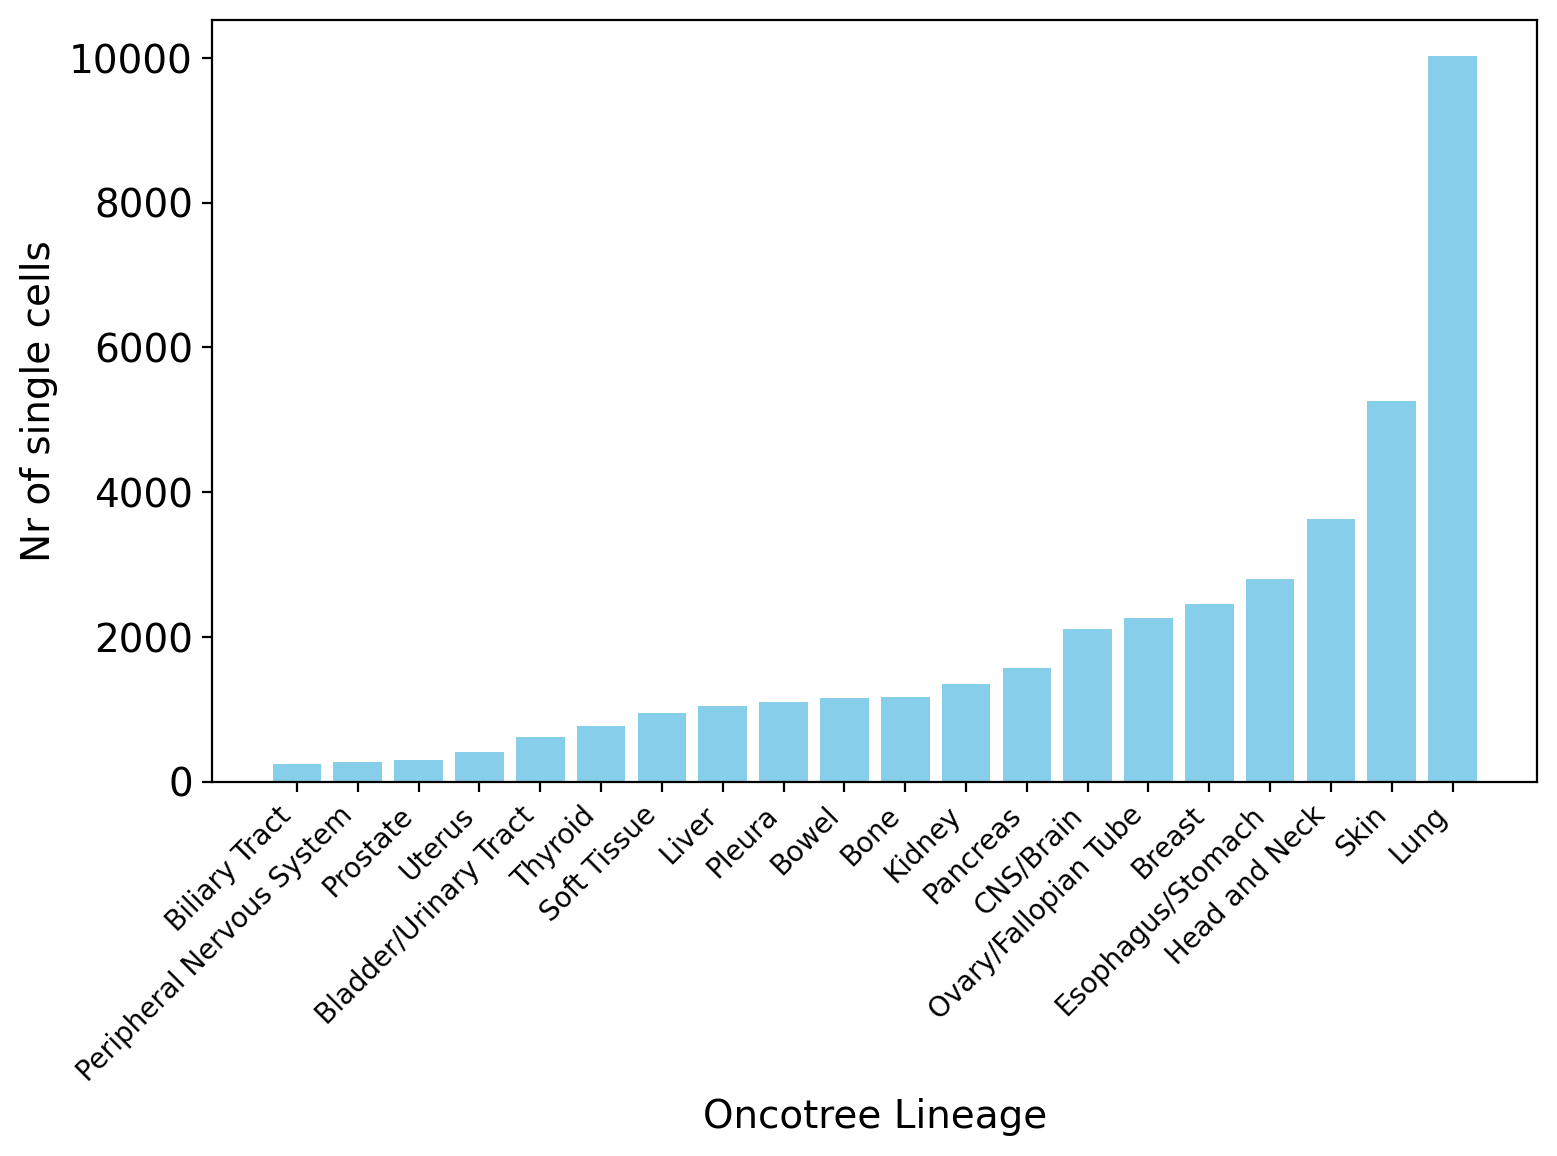

In [21]:
plt.figure(figsize=(8, 6))
plt.bar(counts_lineage["OncotreeLineage"],counts_lineage["count"], color="skyblue")

# Set the title and labels
plt.title("")
plt.xlabel("Oncotree Lineage")
plt.ylabel("Nr of single cells")
plt.xticks(rotation=45, ha='right',fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(None)

# Show the plot
plt.show()

In [22]:
count_data = adata.obs.groupby(['OncotreeLineage', 'OncotreeSubtype', "ModelID"]).size().reset_index(name='count')

In [23]:
counts = pd.DataFrame(count_data["OncotreeLineage"].value_counts()).reset_index()

In [24]:
counts = counts.sort_values(by="count",ascending=True)

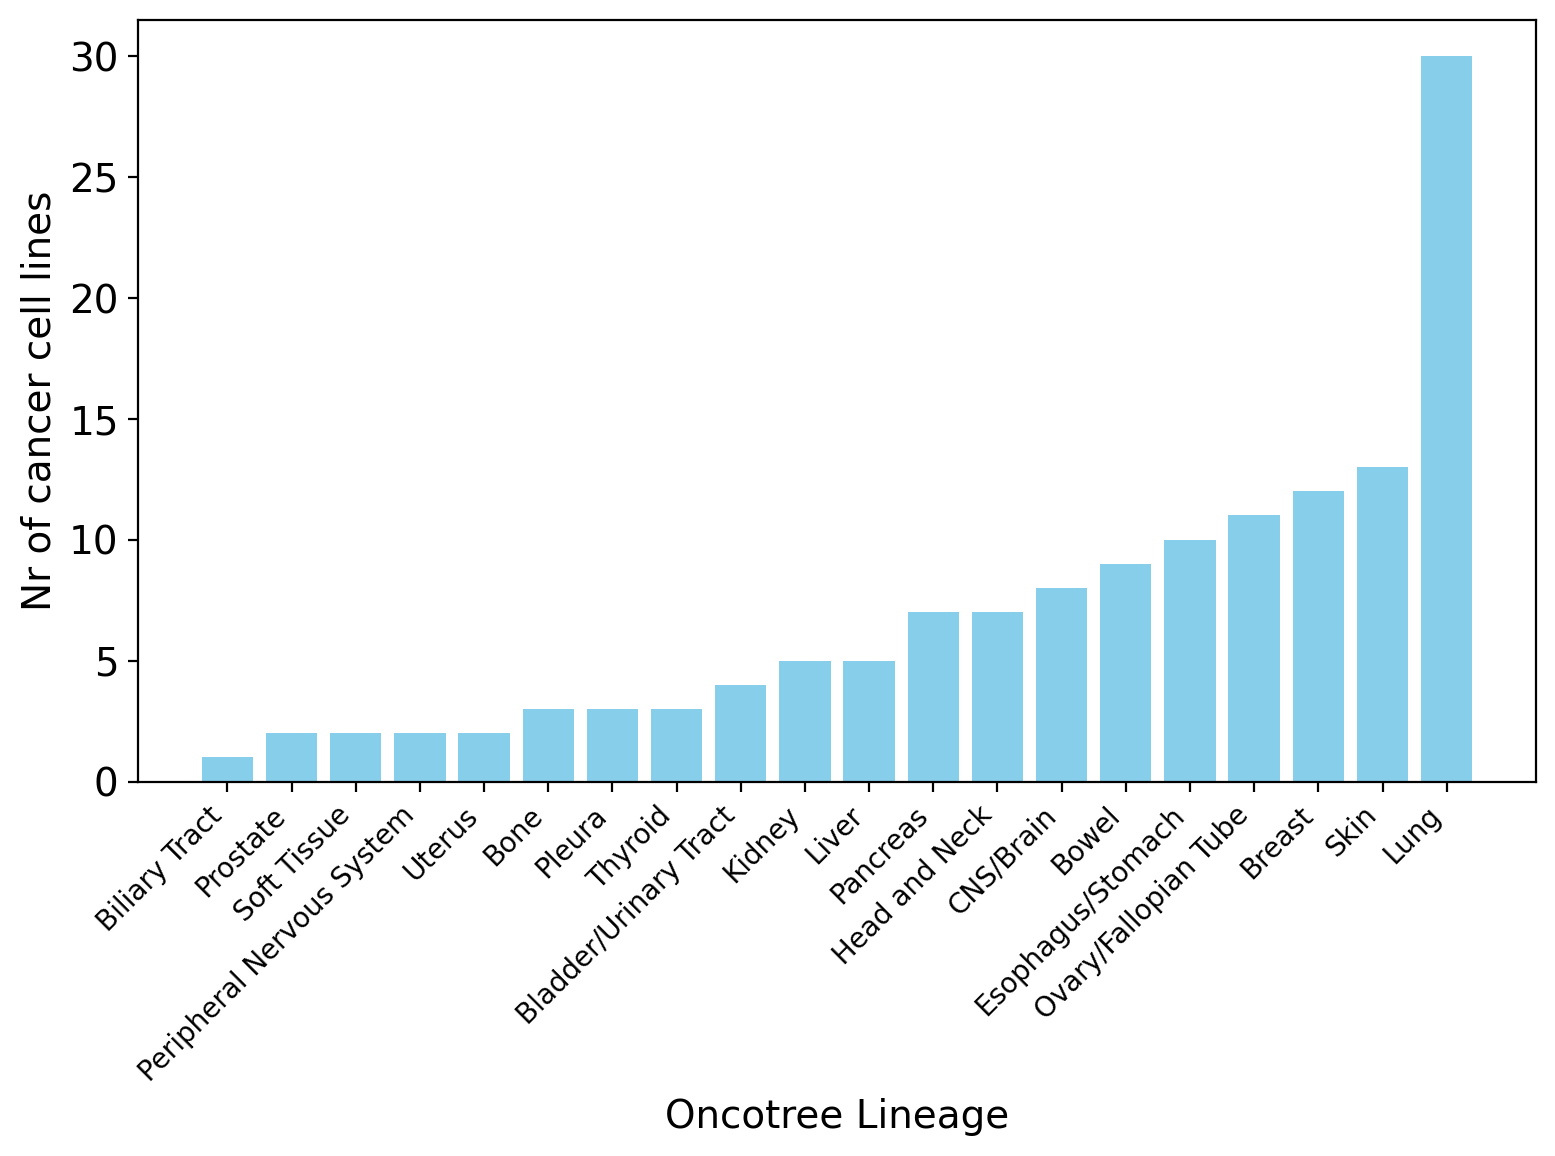

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(counts["OncotreeLineage"],counts["count"], color="skyblue")

# Set the title and labels
plt.title("")
plt.xlabel("Oncotree Lineage")
plt.ylabel("Nr of cancer cell lines")
plt.xticks(rotation=45, ha='right',fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(None)

# Show the plot
plt.show()

In [26]:
adata.shape

(39468, 24452)

In [27]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True)

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  # Log transform
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["OncotreeLineage"])

In [ ]:
sc.pl.umap(adata, color=["n_genes","log1p_total_counts","pct_counts_mt","pct_counts_ribo"])

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["n_genes"], fill=True, ax=axes[0])
sns.histplot(adata.obs["log1p_total_counts"], fill=True, ax=axes[1])
sns.histplot(adata.obs["pct_counts_mt"], fill=True, ax=axes[2])
sns.histplot(adata.obs["pct_counts_ribo"], fill=True, ax=axes[3])

# Set X and Y labels with fontsize
axes[0].set_xlabel("Number of Genes", fontsize=12)
axes[1].set_xlabel("log1p Total Counts", fontsize=12)
axes[2].set_xlabel("Mitochondrial Genes (%)", fontsize=12)
axes[3].set_xlabel("Ribosomal Genes (%)", fontsize=12)

axes[0].set_ylabel("Count", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[2].set_ylabel("Count", fontsize=12)
axes[3].set_ylabel("Count", fontsize=12)

# Adjust tick font sizes for all subplots
for ax in axes:
    ax.tick_params(axis="x", labelsize=10)  # Set font size for x ticks
    ax.tick_params(axis="y", labelsize=10)  # Set font size for y ticks

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#adata.obs["SangerModelID"].unique()[4]

In [94]:
# create dictionary of adata object and normalize data
adata_cl_dict = {}

for CL in adata.obs["SangerModelID"].dropna().unique():
    if CL != " ":
        print(f"Sanger Model ID: {CL}")
        adata_subset = adata[adata.obs["SangerModelID"] == CL].copy()
        # Store raw counts 
        adata_subset.layers['counts'] = adata_subset.X.copy()
        # Normalize data and store in layers
        sc.pp.normalize_total(adata_subset, target_sum=1e4)
        adata_subset.layers["normalized"] = adata_subset.X.copy()
        # Log1p transformation
        sc.pp.log1p(adata_subset)
        adata_subset.layers["log1p"] = adata_subset.X.copy()
        adata_cl_dict[CL] = adata_subset

Sanger Model ID: SIDM00890
Sanger Model ID: SIDM00965
Sanger Model ID: SIDM00333
Sanger Model ID: SIDM01101
Sanger Model ID: SIDM00722
Sanger Model ID: SIDM00614
Sanger Model ID: SIDM00607
Sanger Model ID: SIDM00148
Sanger Model ID: SIDM00676
Sanger Model ID: SIDM00675
Sanger Model ID: SIDM00678
Sanger Model ID: SIDM00731
Sanger Model ID: SIDM00321
Sanger Model ID: SIDM01156
Sanger Model ID: SIDM00778
Sanger Model ID: SIDM00835
Sanger Model ID: SIDM00919
Sanger Model ID: SIDM00306
Sanger Model ID: SIDM00963
Sanger Model ID: SIDM00947
Sanger Model ID: SIDM00122
Sanger Model ID: SIDM00681
Sanger Model ID: SIDM00139
Sanger Model ID: SIDM00683
Sanger Model ID: SIDM00235
Sanger Model ID: SIDM00726
Sanger Model ID: SIDM00956
Sanger Model ID: SIDM00082
Sanger Model ID: SIDM00078
Sanger Model ID: SIDM01105
Sanger Model ID: SIDM00359
Sanger Model ID: SIDM00649
Sanger Model ID: SIDM01066
Sanger Model ID: SIDM00988
Sanger Model ID: SIDM00144
Sanger Model ID: SIDM01060
Sanger Model ID: SIDM00982
S

In [95]:
# this is now a function : "computeHVGs" (utils.py)

for CL, adata in adata_cl_dict.items():
    #print(f"Sanger Model ID: {CL}")
    for N in range(2000, 8500, 500):  # Hyperparameter tuning (number of HVGs)
        # Compute highly variable genes
        sc.pp.highly_variable_genes(adata, n_top_genes=N)
        # Store the new HVG selection separately
        hvg_col_name = f"highly_variable_n{N}"
        adata.var[hvg_col_name] = adata.var["highly_variable"].copy()
        # Ensure HVG genes are NOT mitochondrial or ribosomal
        if "mt" in adata.var.columns and "ribo" in adata.var.columns:
            adata.var[hvg_col_name] = np.logical_and(
                np.logical_xor(
                    np.logical_or(adata.var["mt"], adata.var["ribo"]),
                    adata.var[hvg_col_name]
                ),
                adata.var[hvg_col_name]
            )

#computeHVGs(adata_cl_dict, hvg_range=(2000,8500,500))

In [ ]:
#path_to_list = "/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/"

#with open("".join([path_to_list,"S_phase.txt"])) as f:
    #S_phase = [line.rstrip('\n') for line in f]

#with open("".join([path_to_list,"G2M_phase.txt"])) as f:
    #G2M_phase = [line.rstrip('\n') for line in f]

In [ ]:
#sc.tl.score_genes_cell_cycle(adata, g2m_genes=G2M_phase, s_genes=S_phase)

In [ ]:
#split_columns = adata.obs["cell_line"].str.split("_", n=1, expand=True)
#adata.obs["cell_line"] = split_columns[0]
#adata.obs["tissue"] = split_columns[1]

In [96]:
for cl, adata in adata_cl_dict.items():
    print(f'Sanger Model ID: {cl}')
    for N in range(2000,8500,500):
        adata_hvg = adata[:, adata.var[f"highly_variable_n{N}"]].copy()
        sc.pp.scale(adata_hvg, max_value=10)
        sc.pp.pca(adata_hvg, svd_solver='arpack')
        adata.obsm[f"PCA_n{N}_HVG"] = adata_hvg.obsm["X_pca"]

Sanger Model ID: SIDM00890
Sanger Model ID: SIDM00965
Sanger Model ID: SIDM00333
Sanger Model ID: SIDM01101
Sanger Model ID: SIDM00722
Sanger Model ID: SIDM00614
Sanger Model ID: SIDM00607
Sanger Model ID: SIDM00148
Sanger Model ID: SIDM00676
Sanger Model ID: SIDM00675
Sanger Model ID: SIDM00678
Sanger Model ID: SIDM00731
Sanger Model ID: SIDM00321
Sanger Model ID: SIDM01156
Sanger Model ID: SIDM00778
Sanger Model ID: SIDM00835
Sanger Model ID: SIDM00919
Sanger Model ID: SIDM00306
Sanger Model ID: SIDM00963
Sanger Model ID: SIDM00947
Sanger Model ID: SIDM00122
Sanger Model ID: SIDM00681
Sanger Model ID: SIDM00139
Sanger Model ID: SIDM00683
Sanger Model ID: SIDM00235
Sanger Model ID: SIDM00726
Sanger Model ID: SIDM00956
Sanger Model ID: SIDM00082
Sanger Model ID: SIDM00078
Sanger Model ID: SIDM01105
Sanger Model ID: SIDM00359
Sanger Model ID: SIDM00649
Sanger Model ID: SIDM01066
Sanger Model ID: SIDM00988
Sanger Model ID: SIDM00144
Sanger Model ID: SIDM01060
Sanger Model ID: SIDM00982
S

In [97]:
for cl, adata in adata_cl_dict.items():
    print(f'{cl}:{adata.shape}')
    

SIDM00890:(556, 24452)
SIDM00965:(198, 24452)
SIDM00333:(192, 24452)
SIDM01101:(235, 24452)
SIDM00722:(551, 24452)
SIDM00614:(199, 24452)
SIDM00607:(172, 24452)
SIDM00148:(144, 24452)
SIDM00676:(75, 24452)
SIDM00675:(201, 24452)
SIDM00678:(120, 24452)
SIDM00731:(38, 24452)
SIDM00321:(117, 24452)
SIDM01156:(116, 24452)
SIDM00778:(80, 24452)
SIDM00835:(23, 24452)
SIDM00919:(222, 24452)
SIDM00306:(324, 24452)
SIDM00963:(127, 24452)
SIDM00947:(272, 24452)
SIDM00122:(272, 24452)
SIDM00681:(153, 24452)
SIDM00139:(240, 24452)
SIDM00683:(131, 24452)
SIDM00235:(234, 24452)
SIDM00726:(147, 24452)
SIDM00956:(524, 24452)
SIDM00082:(277, 24452)
SIDM00078:(249, 24452)
SIDM01105:(198, 24452)
SIDM00359:(131, 24452)
SIDM00649:(570, 24452)
SIDM01066:(549, 24452)
SIDM00988:(423, 24452)
SIDM00144:(1185, 24452)
SIDM01060:(833, 24452)
SIDM00982:(561, 24452)
SIDM00795:(726, 24452)
SIDM00887:(304, 24452)
SIDM00828:(659, 24452)
SIDM00797:(469, 24452)
SIDM00368:(226, 24452)
SIDM00213:(151, 24452)
SIDM00238:(493

In [98]:
def doClustering(adata_dict, method="kmeans", hvg_range=(2000, 8500, 500), N_PC=30, cl_range=None):
    
    """
    Performs clustering on a dictionary of AnnData objects using ...

    Parameters:
    - adata_dict (dict): Dictionary containing AnnData objects.
    - method (str): Clustering method. Options: "kmeans", "gmm", ETC.. Default is "kmeans".
    - hvg_range (tuple): (start, stop, step) for the number of highly variable genes. Default: (2000, 8500, 500).

    Returns:
    - Updates `adata.obs` with cluster labels.
    """
    
    import scanpy as sc
    import pandas as pd
    from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
    from sklearn.mixture import GaussianMixture
    
    valid_methods = ("agglomerative", "gmm", "kmeans", "spectral")
    
    if not isinstance(method, str):
        raise TypeError("Error: 'method' must be a string (e.g., 'kmeans', 'gmm', 'agglomerative', 'spectral').")   
    
    if method not in valid_methods:
        raise ValueError(f"Error: Invalid clustering method '{method}'. Choose from {valid_methods}.")
    
    if cl_range is None:
        cl_range = (2,11) # testa da 2 a 10 clusters
    
    if not isinstance(cl_range, tuple) or len(cl_range) != 2:
        raise TypeError("Error: 'cl_range' must be a tuple with two numerical values (min_clusters, max_clusters).")
    
    if not all(isinstance(x, int) and x > 0 for x in cl_range):
        raise ValueError("Error: 'cl_range' must contain two positive integers (e.g., (2, 10)).")
     
    print(f"Running {method} clustering...")
    
    m_mapping = {
        "kmeans": lambda cl: KMeans(n_clusters=cl, random_state=42, n_init=10),
        "gmm": lambda cl: GaussianMixture(n_components=cl, covariance_type="full", random_state=42),
        "agglomerative": lambda cl: AgglomerativeClustering(n_clusters=cl, linkage="ward"), 
        "spectral": lambda cl: SpectralClustering(n_clusters=cl, random_state=42, affinity="nearest_neighbors"),
    }

    for idx, (CL, adata) in enumerate(adata_dict.items()):
        print(f"Processing {idx}: {CL}")
        for N in range(*hvg_range):  
            results = {}
            pca_key = f"PCA_n{N}_HVG"
            adata.obsm["X_pca"] = adata.obsm[pca_key][:, :N_PC]
            pcomp = adata.obsm["X_pca"]
            if method in valid_methods:
                for cl in range(*cl_range):  # 
                    model = m_mapping[method](cl)
                    results[f"{method}_n{N}_{cl}_clusters"] = model.fit_predict(pcomp).astype(str) 
            else:
                raise ValueError(f"Invalid method: {method}. Choose one among {valid_methods}.")

            cluster_df = pd.DataFrame(results, index=adata.obs.index)
            adata.obs = pd.concat([adata.obs, cluster_df], axis=1)
            adata.obs = adata.obs.copy()
                

In [ ]:
doClustering(adata_cl_dict, method="kmeans")

Running kmeans clustering...
Processing 0: SIDM00890
Processing 1: SIDM00965
Processing 2: SIDM00333
Processing 3: SIDM01101
Processing 4: SIDM00722
Processing 5: SIDM00614
Processing 6: SIDM00607
Processing 7: SIDM00148
Processing 8: SIDM00676
Processing 9: SIDM00675
Processing 10: SIDM00678
Processing 11: SIDM00731
Processing 12: SIDM00321
Processing 13: SIDM01156
Processing 14: SIDM00778
Processing 15: SIDM00835
Processing 16: SIDM00919
Processing 17: SIDM00306
Processing 18: SIDM00963
Processing 19: SIDM00947
Processing 20: SIDM00122
Processing 21: SIDM00681
Processing 22: SIDM00139
Processing 23: SIDM00683
Processing 24: SIDM00235
Processing 25: SIDM00726
Processing 26: SIDM00956
Processing 27: SIDM00082
Processing 28: SIDM00078
Processing 29: SIDM01105
Processing 30: SIDM00359
Processing 31: SIDM00649
Processing 32: SIDM01066
Processing 33: SIDM00988
Processing 34: SIDM00144
Processing 35: SIDM01060
Processing 36: SIDM00982
Processing 37: SIDM00795
Processing 38: SIDM00887
Proces

In [36]:
doClustering(adata_cl_dict, method="gmm")

Running gmm clustering...
Processing 0: ACH-000580
Processing 1: ACH-000800
Processing 2: ACH-000988
Processing 3: ACH-000260
Processing 4: ACH-000092
Processing 5: ACH-000848
Processing 6: ACH-000622
Processing 7: ACH-000019
Processing 8: ACH-000547
Processing 9: ACH-000276
Processing 10: ACH-000724
Processing 11: ACH-000399
Processing 12: ACH-000430
Processing 13: ACH-000890
Processing 14: ACH-000403
Processing 15: ACH-000489
Processing 16: ACH-000713
Processing 17: ACH-000672
Processing 18: ACH-000927
Processing 19: ACH-000244
Processing 20: ACH-000288
Processing 21: ACH-000252
Processing 22: ACH-000367
Processing 23: ACH-000977
Processing 24: ACH-000189
Processing 25: ACH-000875
Processing 26: ACH-000717
Processing 27: ACH-001190
Processing 28: ACH-000228
Processing 29: ACH-000423
Processing 30: ACH-000565
Processing 31: ACH-000510
Processing 32: ACH-000650
Processing 33: ACH-000792
Processing 34: ACH-000463
Processing 35: ACH-000882
Processing 36: ACH-000323
Processing 37: ACH-000

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Processing 50: ACH-000945
Processing 51: ACH-000991
Processing 52: ACH-000118
Processing 53: ACH-000934
Processing 54: ACH-000456
Processing 55: ACH-000706
Processing 56: ACH-000948
Processing 57: ACH-000481
Processing 58: ACH-000207
Processing 59: ACH-000437
Processing 60: ACH-000548
Processing 61: ACH-000464
Processing 62: ACH-000352
Processing 63: ACH-000643
Processing 64: ACH-000159
Processing 65: ACH-000443
Processing 66: ACH-000482
Processing 67: ACH-000213
Processing 68: ACH-000470
Processing 69: ACH-000720
Processing 70: ACH-000885
Processing 71: ACH-000171
Processing 72: ACH-000335
Processing 73: ACH-000810
Processing 74: ACH-000147
Processing 75: ACH-000264
Processing 76: ACH-000343
Processing 77: ACH-000243
Processing 78: ACH-000614
Processing 79: ACH-000192
Processing 80: ACH-000814
Processing 81: ACH-000090
Processing 82: ACH-000132
Processing 83: ACH-000663
Processing 84: ACH-000647
Processing 85: ACH-000841
Processing 86: ACH-000117
Processing 87: ACH-000493
Processing 8

In [38]:
resolutions = [0.2,0.4,0.6,0.8,1,1.2]
for idx, (CL, adata) in enumerate(adata_cl_dict.items()):
    print(f'{idx} : {CL}')
    for N in range(2000, 8500, 500):
        adata_hvg = adata[:, adata.var[f"highly_variable_n{N}"]].copy()
        adata_hvg.obsm["X_pca"] = adata.obsm[f"PCA_n{N}_HVG"]
        sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=20)
        #
        adata.obsp[f"connectivities_n{N}_HVG"] = adata_hvg.obsp["connectivities"]
        adata.obsp[f"distances_n{N}_HVG"] = adata_hvg.obsp["distances"]
        adata.uns[f"neighbors_n{N}_HVG"] = adata_hvg.uns["neighbors"]
        #
        for res in resolutions:
            sc.tl.leiden(adata_hvg, resolution=res, random_state=2, n_iterations=-1)
            adata.obs[f"leiden_n{N}_{res}_clusters"] = adata_hvg.obs["leiden"]

0 : ACH-000580


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_550929/3831942385.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=res, random_state=2, n_iterations=-1)


1 : ACH-000800
2 : ACH-000988
3 : ACH-000260
4 : ACH-000092
5 : ACH-000848
6 : ACH-000622
7 : ACH-000019
8 : ACH-000547
9 : ACH-000276
10 : ACH-000724
11 : ACH-000399
12 : ACH-000430
13 : ACH-000890
14 : ACH-000403
15 : ACH-000489
16 : ACH-000713
17 : ACH-000672
18 : ACH-000927
19 : ACH-000244
20 : ACH-000288
21 : ACH-000252
22 : ACH-000367
23 : ACH-000977
24 : ACH-000189
25 : ACH-000875
26 : ACH-000717
27 : ACH-001190
28 : ACH-000228
29 : ACH-000423
30 : ACH-000565
31 : ACH-000510
32 : ACH-000650
33 : ACH-000792
34 : ACH-000463
35 : ACH-000882
36 : ACH-000323
37 : ACH-000219
38 : ACH-000211
39 : ACH-000054
40 : ACH-000788
41 : ACH-000670
42 : ACH-000903
43 : ACH-000947
44 : ACH-000048
45 : ACH-000748
46 : ACH-000217
47 : ACH-000936
48 : ACH-000963
49 : ACH-000929
50 : ACH-000945
51 : ACH-000991
52 : ACH-000118
53 : ACH-000934
54 : ACH-000456
55 : ACH-000706
56 : ACH-000948
57 : ACH-000481
58 : ACH-000207
59 : ACH-000437
60 : ACH-000548
61 : ACH-000464
62 : ACH-000352
63 : ACH-000643
6

In [39]:
method="leiden"
n_pc=20
df_list = []
silhouette_scores = dict()

for idx, (CL, adata) in enumerate(adata_cl_dict.items()):
    print(f'{idx} : {CL}')
    silhouette_scores[CL]={}
    for N in range(2000, 8500, 500):
        pca_key = f"PCA_n{N}_HVG"
        adata.obsm["X_pca"] = adata.obsm[pca_key][:, :n_pc]
        pcomp = adata.obsm["X_pca"]
        silhouette_scores[CL][f'n{N}_HVG'] = dict()
        ranges = range(2, 11) if method in ("gmm", "kmeans") else resolutions
        for var in ranges:
            cl_key = f"{method}_n{N}_{var}_clusters"
            labels = adata.obs[cl_key]
            if method not in ("gmm", "kmeans"):
                cl_count = len(labels.unique())
                if cl_count < 2:
                    continue
            
            score = silhouette_score(pcomp, labels, metric="cosine")
            if method in ("gmm", "kmeans"):
                silhouette_scores[CL][f'n{N}_HVG'][f'{var}_cl'] = score
            else:
                silhouette_scores[CL][f'n{N}_HVG'][f'{cl_count}_cl_{var}_res'] = score

for k in silhouette_scores.keys():
    silhouette_df = pd.DataFrame(
        [
            {
                "Tissue":k,
                "nHVG": n_hvg.split("_")[0],
                "cl": cl.split("_")[0],
                #"res":cl.split("_")[2],
                "SScore": score
            }
            for n_hvg, cl_dict in silhouette_scores[k].items()
            for cl, score in cl_dict.items()])
    
    df_list.append(silhouette_df)

df_leiden=pd.concat(df_list)

0 : ACH-000580
1 : ACH-000800
2 : ACH-000988
3 : ACH-000260
4 : ACH-000092
5 : ACH-000848
6 : ACH-000622
7 : ACH-000019
8 : ACH-000547
9 : ACH-000276
10 : ACH-000724
11 : ACH-000399
12 : ACH-000430
13 : ACH-000890
14 : ACH-000403
15 : ACH-000489
16 : ACH-000713
17 : ACH-000672
18 : ACH-000927
19 : ACH-000244
20 : ACH-000288
21 : ACH-000252
22 : ACH-000367
23 : ACH-000977
24 : ACH-000189
25 : ACH-000875
26 : ACH-000717
27 : ACH-001190
28 : ACH-000228
29 : ACH-000423
30 : ACH-000565
31 : ACH-000510
32 : ACH-000650
33 : ACH-000792
34 : ACH-000463
35 : ACH-000882
36 : ACH-000323
37 : ACH-000219
38 : ACH-000211
39 : ACH-000054
40 : ACH-000788
41 : ACH-000670
42 : ACH-000903
43 : ACH-000947
44 : ACH-000048
45 : ACH-000748
46 : ACH-000217
47 : ACH-000936
48 : ACH-000963
49 : ACH-000929
50 : ACH-000945
51 : ACH-000991
52 : ACH-000118
53 : ACH-000934
54 : ACH-000456
55 : ACH-000706
56 : ACH-000948
57 : ACH-000481
58 : ACH-000207
59 : ACH-000437
60 : ACH-000548
61 : ACH-000464
62 : ACH-000352
63

In [40]:
df_kmm["res"] = np.nan
df_gmm["res"] = np.nan
df_leiden["cl_method"] = "leiden"
df_kmm["cl_method"] = "kmeans"
df_gmm["cl_method"] = "gmm"
df=pd.concat([df_kmm,df_gmm,df_leiden], axis=0, ignore_index=True)

In [ ]:
df.to_csv("/group/iorio/Raffaele/SCDRESP_data/data/clustering_res.csv")

In [3]:
df = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/clustering_res.csv",index_col=0)

In [13]:
idx = df[(df["cl_method"]=="kmeans")].groupby(["Tissue"])["SScore"].idxmax()
df_max_sscore_km = df.loc[idx].reset_index(drop=True)
df_max_sscore_km.to_csv("/group/iorio/Raffaele/SCDRESP_data/data/clustering_res_km.csv")

In [14]:
idx = df[(df["cl_method"]=="gmm")].groupby(["Tissue"])["SScore"].idxmax()
df_max_sscore_gmm = df.loc[idx].reset_index(drop=True)
df_max_sscore_gmm.to_csv("/group/iorio/Raffaele/SCDRESP_data/data/clustering_res_gmm.csv")

In [15]:
idx = df[(df["cl_method"]=="leiden")].groupby(["Tissue"])["SScore"].idxmax()
df_max_sscore_leiden = df.loc[idx].reset_index(drop=True)
df_max_sscore_leiden.to_csv("/group/iorio/Raffaele/SCDRESP_data/data/clustering_res_leiden.csv")

In [42]:
df_kmm=df[df["cl_method"] == "kmeans"]
df_gmm=df[df["cl_method"] == "gmm"]
df_leiden=df[df["cl_method"] == "leiden"]

In [ ]:
df_649_kmm = df_kmm[df_kmm["Tissue"] == "SIDM00649"]
df_649_gmm = df_gmm[df_gmm["Tissue"] == "SIDM00649"]
df_649_leiden = df_leiden[df_leiden["Tissue"] == "SIDM00649"]

In [ ]:
nHVG_values = df_649_kmm['nHVG'].unique()

cols = 4 
rows = math.ceil(len(nHVG_values) / cols) 

# Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
axes = axes.flatten()

# Loop through each nHVG value and plot on the corresponding subplot
for i, nHVG in enumerate(nHVG_values):
    # Filter the DataFrame for the current nHVG value
    subset = df_649_kmm[df_649_kmm['nHVG'] == nHVG]

    # Plot the barplot for the current nHVG value
    sns.barplot(x='cl', y='SScore', data=subset, ax=axes[i])
    
    # Set title and labels for each subplot
    axes[i].set_title(f'nHVG = {nHVG}')
    axes[i].set_xlabel('Nr of clusters')
    axes[i].set_ylabel('SScore')

# Hide unused subplots if the grid is larger than the number of plots
for i in range(len(nHVG_values), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df_kmm["SScore"], ax=axes[0], )
sns.histplot(df_gmm["SScore"], ax=axes[1])
sns.histplot(df_leiden["SScore"], ax=axes[2])
axes[0].set_xlabel("Silhouette Score", fontsize=12)
axes[1].set_xlabel("Silhouette Score", fontsize=12)
axes[2].set_xlabel("Silhouette Score", fontsize=12)

axes[0].set_ylabel("Frequency", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[2].set_ylabel("Frequency", fontsize=12)

axes[0].set_ylabel("Frequency", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[2].set_ylabel("Frequency", fontsize=12)

axes[0].set_title("K-means")
axes[1].set_title("Gaussian Mixture")
axes[2].set_title("Leiden")

axes[0].axvline(0.29, color='red', linestyle='--')
axes[1].axvline(0.29, color='red', linestyle='--')
axes[2].axvline(0.29, color='red', linestyle='--')

axes[0].grid(False)
axes[1].grid(False)
axes[2].grid(False)

for ax in axes:
    ax.tick_params(axis="x", labelsize=10)  # Set font size for x ticks
    ax.tick_params(axis="y", labelsize=10)  # Set font size for y ticks


In [44]:
df

,Tissue,nHVG,cl,SScore,res,cl_method
0,SIDM00890,n2000,2,0.311341,NaN,kmeans
1,SIDM00890,n2000,3,0.283334,NaN,kmeans
2,SIDM00890,n2000,4,0.212419,NaN,kmeans
3,SIDM00890,n2000,5,0.196435,NaN,kmeans
4,SIDM00890,n2000,6,0.215900,NaN,kmeans
...,...,...,...,...,...,...
43814,SIDM00128,n8000,4,0.204483,0.4,leiden
43815,SIDM00128,n8000,5,0.204423,0.6,leiden
43816,SIDM00128,n8000,7,0.211020,0.8,leiden
43817,SIDM00128,n8000,8,0.208880,1.0,leiden


In [45]:
df=df[df["SScore"]>=0.29] # 0.29 silhouette score threshold
df=df.loc[df.groupby("Tissue")["SScore"].idxmax()]
df=df.rename(columns={"Tissue":"CellLine"})
df["cl"].value_counts()

cl
2    55
3    14
4     6
5     2
6     1
Name: count, dtype: int64

In [46]:
df

,CellLine,nHVG,cl,SScore,res,cl_method
35505,SIDM00078,n3500,5,0.334268,0.6,leiden
15697,SIDM00080,n3000,3,0.319786,NaN,kmeans
3276,SIDM00082,n2000,2,0.344292,NaN,kmeans
39370,SIDM00088,n6500,2,0.333441,0.4,leiden
38783,SIDM00097,n2000,2,0.349790,0.2,leiden
...,...,...,...,...,...,...
37806,SIDM01155,n3000,2,0.452081,0.2,leiden
34365,SIDM01156,n2000,4,0.307897,0.6,leiden
38515,SIDM01169,n5500,3,0.373553,0.6,leiden
43545,SIDM01188,n5000,2,0.311891,0.4,leiden


In [ ]:
df.to_csv("filtered_clustering_res.csv")

In [ ]:
df[df["CellLine"] =="SIDM00649"]

In [ ]:
df = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/clustering_res.csv",index_col=0)

In [ ]:
sns.barplot(df["cl"].value_counts())

In [55]:
with open("/group/iorio/Raffaele/SCDRESP_data/data/adata_dict.pkl", "rb") as f:
    adata_paths=pickle.load(f)

In [56]:
sub_adata_cl_dict={key: anndata.read_h5ad(path) for key, path in adata_paths.items()}

In [63]:
sub_adata_cl_dict = dict()
for cl in df["CellLine"].unique():
    sub_adata_cl_dict[cl] = adata_cl_dict[cl]


KeyError: 'SIDM00078'

In [68]:
df["CellLine"].unique()

array(['SIDM00078', 'SIDM00080', 'SIDM00082', 'SIDM00088', 'SIDM00097',
       'SIDM00108', 'SIDM00116', 'SIDM00119', 'SIDM00122', 'SIDM00128',
       'SIDM00131', 'SIDM00139', 'SIDM00148', 'SIDM00213', 'SIDM00235',
       'SIDM00239', 'SIDM00247', 'SIDM00305', 'SIDM00306', 'SIDM00317',
       'SIDM00335', 'SIDM00359', 'SIDM00369', 'SIDM00392', 'SIDM00395',
       'SIDM00425', 'SIDM00481', 'SIDM00486', 'SIDM00487', 'SIDM00494',
       'SIDM00528', 'SIDM00533', 'SIDM00587', 'SIDM00597', 'SIDM00615',
       'SIDM00629', 'SIDM00640', 'SIDM00649', 'SIDM00654', 'SIDM00663',
       'SIDM00672', 'SIDM00681', 'SIDM00683', 'SIDM00690', 'SIDM00708',
       'SIDM00716', 'SIDM00718', 'SIDM00726', 'SIDM00729', 'SIDM00750',
       'SIDM00795', 'SIDM00798', 'SIDM00831', 'SIDM00881', 'SIDM00882',
       'SIDM00890', 'SIDM00919', 'SIDM00920', 'SIDM00921', 'SIDM00945',
       'SIDM00947', 'SIDM00950', 'SIDM00963', 'SIDM00980', 'SIDM00988',
       'SIDM00997', 'SIDM01002', 'SIDM01070', 'SIDM01080', 'SIDM

In [73]:
adata_cl_dict.keys()

dict_keys(['ACH-000580', 'ACH-000800', 'ACH-000988', 'ACH-000260', 'ACH-000092', 'ACH-000848', 'ACH-000622', 'ACH-000019', 'ACH-000547', 'ACH-000276', 'ACH-000724', 'ACH-000399', 'ACH-000430', 'ACH-000890', 'ACH-000403', 'ACH-000489', 'ACH-000713', 'ACH-000672', 'ACH-000927', 'ACH-000244', 'ACH-000288', 'ACH-000252', 'ACH-000367', 'ACH-000977', 'ACH-000189', 'ACH-000875', 'ACH-000717', 'ACH-001190', 'ACH-000228', 'ACH-000423', 'ACH-000565', 'ACH-000510', 'ACH-000650', 'ACH-000792', 'ACH-000463', 'ACH-000882', 'ACH-000323', 'ACH-000219', 'ACH-000211', 'ACH-000054', 'ACH-000788', 'ACH-000670', 'ACH-000903', 'ACH-000947', 'ACH-000048', 'ACH-000748', 'ACH-000217', 'ACH-000936', 'ACH-000963', 'ACH-000929', 'ACH-000945', 'ACH-000991', 'ACH-000118', 'ACH-000934', 'ACH-000456', 'ACH-000706', 'ACH-000948', 'ACH-000481', 'ACH-000207', 'ACH-000437', 'ACH-000548', 'ACH-000464', 'ACH-000352', 'ACH-000643', 'ACH-000159', 'ACH-000443', 'ACH-000482', 'ACH-000213', 'ACH-000470', 'ACH-000720', 'ACH-0008

In [59]:
# compute UMAPs only for cell lines with multiple clones
sub_adata_cl_dict = dict()
for cl in df["CellLine"].unique():
    sub_adata_cl_dict[cl] = adata_cl_dict[cl]

for idx, (CL, adata) in enumerate(sub_adata_cl_dict.items()):
    print(f'{idx} : {CL}')
    nHVG=df.loc[df["CellLine"]==CL]["nHVG"].values[0]
    adata.obsp["connectivities"]=adata.obsp[f"connectivities_{nHVG}_HVG"]
    adata.obsp["distances"] = adata.obsp[f"distances_{nHVG}_HVG"]
    adata.uns["neighbors"] = adata.uns[f"neighbors_{nHVG}_HVG"]
    sc.tl.umap(adata, min_dist=0.3, spread=1.0)
    adata.obsm[f"umap_{nHVG}_HVG"] = adata.obsm["X_umap"]

KeyError: 'SIDM00078'

In [ ]:
hvg_dict = {}

for CL in df["CellLine"].unique():
    nHVG=df.loc[df["CellLine"]==CL]["nHVG"].values[0]
    for cl, adata in sub_adata_cl_dict.items():
        s=adata.var[f"highly_variable_{nHVG}"]
        HVG=s.index[s]
        hvg_dict[CL]=len(HVG)

#U=list(set().union(*hvg_dict.values()))
#print(U)
plt.figure(figsize=(5, 5))
sns.kdeplot(hvg_dict.values())
plt.title("")
plt.xlabel("Nr of HVG")
plt.ylabel("Density")
plt.show()

In [ ]:
cell_lines = df["CellLine"].unique()
num_plots = len(cell_lines)

# Determine grid size (approximate square layout)
cols = 7 # math.ceil(math.sqrt(num_plots))
rows = math.ceil(num_plots / cols) 

# Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))

axes = axes.flatten()

for idx, CL in enumerate(cell_lines): 
    adata = sub_adata_cl_dict[CL].copy()  # Make sure this is reloaded
    cell_data = df.loc[df["CellLine"] == CL].iloc[0]  # Extract row as a Series
    nHVG = cell_data["nHVG"]
    method = cell_data["cl_method"]
    var = cell_data["res"] if method == "leiden" else cell_data["cl"]
    cl_key = f"{method}_{nHVG}_{var}_clusters"
    # Assign correct UMAP
    adata.obsm["X_umap"] = adata.obsm[f"umap_{nHVG}_HVG"]
    # Plot UMAP on the assigned subplot
    sc.pl.umap(adata, color=cl_key, title=f'{CL};N cells: {adata.n_obs}; HVG:{nHVG}', ax=axes[idx], show=False)
    
# Hide unused subplots if the grid is larger than the number of plots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#
from matplotlib.backends.backend_pdf import PdfPages
pdf_path = "/group/iorio/Raffaele/SCDRESP_data/data/figures/umap_panel.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight') 
    plt.close(fig) 


In [ ]:
dir_path = "/group/iorio/Raffaele/Project_ADD3/review/h5ad_files/"
adata_paths = {}

for key, adata in sub_adata_cl_dict.items():
    file_name = f"{key}.h5ad"
    file_path = os.path.join(dir_path, file_name) 
    adata.obs = adata.obs.rename(columns=str)
    adata.obs = adata.obs.astype(str)
    adata.write(file_path)
    adata_paths[key] = file_path  

with open("adata_dict.pkl", "wb") as f:
    pickle.dump(adata_paths, f)

In [ ]:
with open("/group/iorio/Raffaele/Project_ADD3/review/h5ad_files/adata_dict.pkl", "rb") as f:
    adata_paths = pickle.load(f)

In [ ]:
sub_adata_cl_dict = {key: anndata.read_h5ad(path) for key, path in adata_paths.items()}

In [ ]:
len(sub_adata_cl_dict.keys())

In [ ]:
# Define the GTF file path
#gtf_file = "/group/iorio/Raffaele/Project_ADD3/review/sc_CCLs_Broad/SCP542/metadata/Homo_sapiens.GRCh38.100.gtf"  # Change path if needed

# Dictionary to store gene lengths
#gene_lengths = {}

# Read and parse the GTF file
#with open(gtf_file, "r") as f:
#    for line in f:
#        if line.startswith("#"):
#            continue  # Skip header lines
        
#        columns = line.strip().split("\t")
#        feature_type = columns[2]  # Type of feature (gene, transcript, exon, etc.)

#        if feature_type == "gene":  # Extract only gene-level entries
#            start = int(columns[3])
#            end = int(columns[4])
#            gene_length = end - start  # Compute gene length

            # Extract gene_id and gene_name from attributes column
#            attributes = columns[8]
#            attr_dict = {}
#            for attr in attributes.split(";"):
#                if attr.strip():
#                    key, value = attr.strip().split(" ")
#                    attr_dict[key] = value.strip('"')

#            gene_id = attr_dict.get("gene_id", "unknown")
#            gene_name = attr_dict.get("gene_name", gene_id)  # Use gene_id if no name found
            
            # Store in dictionary
#            gene_lengths[gene_id] = {"Gene_Name": gene_name, "Length": gene_length}

# Convert to DataFrame
#gene_lengths_df = pd.DataFrame.from_dict(gene_lengths, orient="index")
#gene_lengths_df.index.name = "Gene_ID"

# Save to CSV
#gene_lengths_df.to_csv("gene_lengths.csv")

# Display the first few rows
#print(gene_lengths_df.head())

In [ ]:
for idx, adata in sub_adata_cl_dict.items():
    print(idx, adata.shape)

In [ ]:
# Load gene lengths from a GTF file (or use a precomputed dictionary)
gene_lengths = pd.read_csv("gene_lengths.csv", index_col=0)

In [ ]:
gene_lengths.set_index("Gene_Name", inplace=True)

In [ ]:
adata_combined.var_names

In [ ]:
sub_adata_aggrGEPs_cl_dict = {}
for idx, CL in enumerate(cell_lines):
    print(f'{idx} : {CL}')
    adata = sub_adata_cl_dict[CL].copy()  
    cell_data = df.loc[df["CellLine"] == CL].iloc[0]
    nHVG = cell_data["nHVG"]
    method = cell_data["cl_method"]
    var = cell_data["res"] if method == "leiden" else cell_data["cl"]
    cl_key = f"{method}_{nHVG}_{var}_clusters"

    counts_df = pd.DataFrame(adata.layers["counts"].toarray() if hasattr(adata.layers["counts"], "toarray") else adata.layers["counts"],
                             index=adata.obs_names, 
                             columns=adata.var_names)
    
    aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
    GENES = aggr_counts_df.columns.intersection(gene_lengths.index)
    
    LEN_GENES = gene_lengths[gene_lengths.index.isin(GENES)]["Length"]
    LEN_GENES = LEN_GENES[~LEN_GENES.index.duplicated(keep="first")]
    
    aggr_counts_df = aggr_counts_df.loc[:,GENES]
    rpk = aggr_counts_df.div(LEN_GENES, axis=1)  # Reads Per Kilobase
    total_rpk = rpk.sum(axis=1)  # Sum of all RPK values per sample
    tpm = rpk.div(total_rpk, axis=0) * 1e6  # Scale to TPM
    adata_aggr = sc.AnnData(tpm)
    sub_adata_aggrGEPs_cl_dict[CL] = adata_aggr

adata_combined = sc.concat(list(sub_adata_aggrGEPs_cl_dict.values()), join="inner", label="ID", keys=list(sub_adata_aggrGEPs_cl_dict.keys()))
adata_df = pd.DataFrame(adata_combined.X, index=adata_combined.obs_names, columns=adata_combined.var_names)
adata_df["CellLine"] = adata_combined.obs["ID"].values
adata_df["Clone_ID"] = adata_df["CellLine"].astype(str) + "_clone_" + adata_df.index.astype(str)
adata_df.reset_index(inplace=True, drop=True)
adata_df

In [ ]:
# Ensure only valid genes are kept
hvg_to_keep = [g for g in U if g in adata_df.columns]
meta_df = adata_df[["CellLine", "Clone_ID"]]
adata_hvg_df = adata_df[hvg_to_keep].copy()  
#adata_impure = sc.AnnData(adata_hvg_df)
adata_hvg_df["CellLine"] = meta_df["CellLine"].copy()
adata_hvg_df["Clone_ID"] = meta_df["Clone_ID"].copy()

In [ ]:
metadata = pd.read_csv("metadata_pureANDclones_CLs.csv",index_col=0)
metadata_impure = metadata[metadata["class"]=="impure"]

In [ ]:
adata_hvg_df["CellLine"].unique()

In [ ]:
CLs=list(adata_hvg_df["CellLine"].unique())
META=adata.obs[adata.obs["CellLineName"].isin(CLs)][["CellLineName","OncotreeLineage"]]
META.drop_duplicates(subset="CellLineName", keep="first",inplace=True)
META.rename(columns={"CellLineName":"CellLine"}, inplace=True)
adata_hvg_df = adata_hvg_df.merge(META, on="CellLine", how="left")

In [ ]:
sub_adata_cl_dict_pure = dict()

for cl in adata_cl_dict.keys():
    if cl not in df["CellLine"].unique():
        sub_adata_cl_dict_pure[cl] = adata_cl_dict[cl]

sub_adata_aggrGEPs_cl_dict_pure = {}

for idx, (CL, adata) in enumerate(sub_adata_cl_dict_pure.items()):
    print(f'{idx} : {CL}')
    counts= adata.layers["counts"].toarray() if hasattr(adata.layers["counts"], "toarray") else adata.layers["counts"]
    aggr_counts_df = pd.DataFrame(counts, index=adata.obs_names, columns=adata.var_names).sum(axis=0).to_frame().T 
    GENES = aggr_counts_df.columns.intersection(gene_lengths.index)
    LEN_GENES = gene_lengths[gene_lengths.index.isin(GENES)]["Length"]
    LEN_GENES = LEN_GENES[~LEN_GENES.index.duplicated(keep="first")]
    aggr_counts_df = aggr_counts_df.loc[:,GENES]
    rpk = aggr_counts_df.div(LEN_GENES, axis=1)  # Reads Per Kilobase
    total_rpk = rpk.sum(axis=1)  # Sum of all RPK values per sample
    tpm = rpk.div(total_rpk, axis=0) * 1e6  # Scale to TPM
    adata_aggr = sc.AnnData(tpm)
    sub_adata_aggrGEPs_cl_dict_pure[CL] = adata_aggr

adata_combined_pure=sc.concat(list(sub_adata_aggrGEPs_cl_dict_pure.values()), join="inner",label="ID",keys=list(sub_adata_aggrGEPs_cl_dict_pure.keys()))
adata_df_pure = pd.DataFrame(adata_combined_pure.X, index=adata_combined_pure.obs_names, columns=adata_combined_pure.var_names)
adata_df_pure["CellLine"] = adata_combined_pure.obs["ID"].values
adata_df_pure.reset_index(inplace=True,drop=True) 
adata_df_pure

In [ ]:
adata_df_pure["class"] = "labeled"
adata_df_pure["Clone_ID"] = np.nan
adata_df["class"] = "unlabeled"

In [ ]:
metadata_df = adata.obs[["CellLineName","OncotreeLineage","OncotreeSubtype","ModelID","COSMICID","SangerModelID"]]
metadata_df.drop_duplicates(subset="SangerModelID", keep="first",inplace=True)

In [ ]:
metadata_pure = metadata_df[metadata_df["CellLineName"].isin(adata_df_pure["CellLine"])][["OncotreeLineage","OncotreeSubtype","ModelID","COSMICID","SangerModelID"]]
metadata_clones = metadata_df[metadata_df["CellLineName"].isin(adata_df["CellLine"])][["OncotreeLineage","OncotreeSubtype","ModelID","COSMICID","SangerModelID"]]
metadata_pure["class"] = "pure"
metadata_clones["class"] = "impure"

In [ ]:
pd.concat([metadata_pure,metadata_clones],axis=0, ignore_index=True).to_csv("metadata_pureANDclones_CLs.csv")

In [ ]:
metadata = pd.read_csv("metadata_pureANDclones_CLs.csv",index_col=0)
metadata
metadata_pure = metadata[metadata["class"] == "pure"]
metadata_clones = metadata[metadata["class"] == "impure"]
metadata_pure["class"] = "pure"
metadata_clones["class"] = "impure"

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x=metadata_pure["OncotreeLineage"].value_counts().index, y=metadata_pure["OncotreeLineage"].value_counts().values,ax=axes[0])
sns.barplot(x=metadata_clones["OncotreeLineage"].value_counts().index, y=metadata_clones["OncotreeLineage"].value_counts().values,ax=axes[1])
axes[0].tick_params(axis="x", rotation=45)  # Rotate labels
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha="right")  # Align text
axes[0].set_title("labeled (pure)")
axes[0].set_ylabel("N of cell lines")
axes[1].tick_params(axis="x", rotation=45)  # Rotate labels
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha="right")  # Align text
axes[1].set_title("unlabeled (impure)")
axes[1].set_ylabel("N of cell lines")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Count occurrences for each OncotreeLineage in both datasets
pure_counts = metadata_pure["OncotreeLineage"].value_counts()
impure_counts = metadata_clones["OncotreeLineage"].value_counts()

# Create a DataFrame with counts for both categories
df_counts = pd.DataFrame({
    "Tissue": pure_counts.index.union(impure_counts.index),  # Ensure all tissues are included
    "Pure": pure_counts.reindex(pure_counts.index.union(impure_counts.index), fill_value=0).values,
    "Impure": impure_counts.reindex(pure_counts.index.union(impure_counts.index), fill_value=0).values
})

# Sort by "Pure" count (descending)
df_counts = df_counts.sort_values(by="Pure", ascending=False)

# Melt DataFrame for seaborn compatibility (long format)
df_melted = df_counts.melt(id_vars=["Tissue"], var_name="Category", value_name="Count")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Tissue", y="Count", hue="Category", palette=["blue", "red"], order=df_counts["Tissue"])

# Formatting
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.ylabel("N of Cell Lines")
plt.xlabel("Oncotree Lineage")
plt.title("Comparison of Pure and Impure Cell Lines per Tissue (Ordered by Pure Count)")
plt.legend(title="Category")
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
pd.concat([adata_df,adata_df_pure],axis=0, ignore_index=True).to_csv("TPM_aggrCounts_across_CLs.csv")

In [ ]:
TPM=pd.read_csv("TPM_aggrCounts_across_CLs.csv",index_col=0)

In [ ]:
TPM[TPM["class"] == "unlabeled"]["Clone_ID"]

In [ ]:
adata.obs["CellLineName"].isin()

In [ ]:
DF_IMPURE = TPM[TPM["class"] == "unlabeled"]
CLs=TPM[TPM["class"] == "unlabeled"]["CellLine"]
META=adata.obs[adata.obs["CellLineName"].isin(CLs)][["CellLineName","OncotreeLineage"]]
META.drop_duplicates(subset="CellLineName", keep="first",inplace=True)
META.rename(columns={"CellLineName":"CellLine"}, inplace=True)
DF_MERGED = DF_IMPURE.merge(META, on="CellLine", how="left")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
S_scaled=pd.DataFrame(scaler.fit_transform(DF_MERGED.iloc[:,:-4]))
S_scaled["tissue"] = DF_MERGED["OncotreeLineage"]
corrMat = S_scaled.groupby("tissue").apply(lambda g: g.iloc[:, :-1].T.corr())
utr=corrMat.where(np.triu(np.ones(corrMat.shape),k=1).astype(bool))
intra_corr_values=utr.stack().values

In [ ]:
S=DF_MERGED[DF_MERGED["class"] == "unlabeled"].iloc[:,:-4]
index=DF_MERGED[DF_MERGED["class"] == "unlabeled"]["Clone_ID"]
S.set_index(index,inplace=True)
S_scaled=pd.DataFrame(scaler.fit_transform(S), columns=S.columns)
corrMat=S_scaled.T.corr()
utr=corrMat.where(np.triu(np.ones(corrMat.shape),k=1).astype(bool))
corr_values=utr.stack().values
plt.figure(figsize=(8, 5))
sns.kdeplot(corr_values, fill=True, color="grey", alpha=0.6)
sns.kdeplot(intra_corr_values, fill=True, color="green", alpha=0.6)
plt.title("Density Plot of Correlation Values")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Density")
plt.show()

In [ ]:
import scipy.stats as stats 
t_stat, p_value = stats.ttest_ind(corr_values, intra_corr_values)
print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

In [ ]:
import astropy.stats as ap
for t in df["Tissue"].unique():
    N = len(adata_ots_dict[t].obs["CellLineName"].unique())  # Get number of cell lines
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
    axes = axes.flatten()
    for idx, method in enumerate(["kmeans", "gmm"]):
        df_method = df[(df["cl_method"] == method) & (df["Tissue"] == t)]  # Filter once
        for n in df["nHVG"].unique():
            df_subset = df_method[df_method["nHVG"] == n]  # Filter per HVG value
            median = df_method["SScore"].median()
            mad = ap.median_absolute_deviation(df_method["SScore"])
            threshold = median + 2 * mad
            sns.lineplot(data=df_subset, x='cl', y='SScore', label=f"HVG {n}", ax=axes[idx])
        
        axes[idx].set_xticks(df["cl"].unique())  # Only plot actual cluster values
        axes[idx].axhline(y=median, color='grey', linestyle='-', linewidth=1)
        axes[idx].axhline(y=threshold, color='red', linestyle='--', linewidth=1)
        # Customize each subplot
        axes[idx].set_title(f"{method.upper()} - {t} ({N} cell lines)", fontsize=12)
        axes[idx].set_xlabel("Number of Clusters", fontsize=10)
        axes[idx].set_ylabel("Silhouette Score", fontsize=10)
        axes[idx].legend(title="HVG Count", fontsize=8)
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
import astropy.stats as ap
for t in df["Tissue"].unique():
    N = len(adata_ots_dict[t].obs["CellLineName"].unique())  # Get number of cell lines
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
    axes = axes.flatten()
    for idx, method in enumerate(["kmeans", "gmm"]):
        df_method = df[(df["cl_method"] == method) & (df["Tissue"] == t)]  # Filter once
        for n in df["nHVG"].unique():
            df_subset = df_method[df_method["nHVG"] == n]  # Filter per HVG value
            median = df_method["SScore"].median()
            mad = ap.median_absolute_deviation(df_method["SScore"])
            threshold = median + 2 * mad
            sns.lineplot(data=df_subset, x='cl', y='SScore', label=f"HVG {n}", ax=axes[idx])
        
        axes[idx].set_xticks(df["cl"].unique())  # Only plot actual cluster values
        axes[idx].axhline(y=median, color='grey', linestyle='-', linewidth=1)
        axes[idx].axhline(y=threshold, color='red', linestyle='--', linewidth=1)
        # Customize each subplot
        axes[idx].set_title(f"{method.upper()} - {t} ({N} cell lines)", fontsize=12)
        axes[idx].set_xlabel("Number of Clusters", fontsize=10)
        axes[idx].set_ylabel("Silhouette Score", fontsize=10)
        axes[idx].legend(title="HVG Count", fontsize=8)
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
for t in df["Tissue"].unique():
    N = len(adata_ots_dict[t].obs["CellLineName"].unique())
    #plt.figure(figsize=(9, 4))  # Create a new figure for each tissue
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
    axes = axes.flatten()
    for idx, method in enumerate(list("kmeans","gmm")):
        df_subset =df[(df["cl_method"] == method)]
        for n in df["nHVG"].unique():
            df_subset = df_subset[(df_subset["Tissue"] == t) & (df_subset["nHVG"] == n)]
            sns.lineplot(data=df_subset, x='cl', y='SScore', label=f"HVG {n}",ax=axes[idx])

    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"{t}:{N} cell lines")
    plt.legend(title="HVG Count", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.grid(True)
    plt.show()

In [ ]:
# columns_to_delete = []
# adata.obs.drop(columns=[columns_to_delete],inplace=True) # before saving adata

In [ ]:
import anndata
for k, adata in adata_ots_dict.items():
    print(k, adata)
anndata.AnnData.write_h5ad(adata, filename="/group/iorio/Raffaele/Project_ADD3/review/sc_CCLs_Broad/SCP542/other/adataObj.h5ad", compression="gzip")

In [ ]:
adata=sc.read_h5ad("/group/iorio/Raffaele/Project_ADD3/review/sc_CCLs_Broad/SCP542/other/adataObj.h5ad")